# Quadratische Diskriminantenanalyse - Alternativlösung von Adrian Lutsch

In dieser Übung werden Sie selbst eine quadratische Diskriminantenanalyse (QDA) implementieren. Zur Erinnerung: Die QDA berechnet $p(x|y)=\frac{p(y|x)*p(x)}{p(y)}$. Die Likelihood $p(y|x)$ wird als normalverteilt angenommen.

## Aufgabe 1
Eine Fischerin benötigt Ihre Hilfe bei der Klassifikation von Fischen. Vor kurzem hat sie folgende Fische gefangen: 

| Länge (m)    | Art          | 
| ------------- |-------------  |
| 1.3           | Barsch       |
| 0.7           | Lachs       |
| 0.62           | Lachs      |
| 0.9           | Lachs       |
| 0.91          | Barsch       |
| 0.31          | Hering       |
| 0.26           | Hering       |

* Berechnen Sie die Priors $p(\omega)$ für jede Fischart
* Berechnen Sie die Parameter $\mu$ und $\sigma^2$ für die Lkelihoods $p(x|\omega)$. 
* Die Fischerin fängt einen neuen Fisch mit Länge $x = 0.82 m$. Berechen Sie die Posterior-Wahrscheinlichkeit $p(\omega|x)$ für jede Klasse. Wie wird der Fisch klassifiziert?

In [14]:
p_barsch = 2/7
p_lachs = 3/7
p_hering = 2/7

# Das sind die Schulvarianten von Mittelwert und Varianz. Nicht die Bias-bereinigten
mean_barsch = (1.3 + 0.91) / 2
mean_lachs = (0.7 + 0.62 + 0.9) / 3
mean_hering = (0.31 + 0.26) / 2

var_barsch = 1/2 * (1.3 - mean_barsch) ** 2 + (0.91 - mean_barsch) ** 2
var_lachs = 1/3 * (0.7 - mean_lachs) ** 2 + (0.62 - mean_lachs) ** 2 + (0.9 - mean_lachs) ** 2
var_hering = 1/2 * (0.31 - mean_hering) ** 2 + (0.26 - mean_hering) ** 2

In [2]:
print(f"{mean_barsch} ± {var_barsch}", f"{mean_lachs} ± {var_lachs}", f"{mean_hering} ± {var_hering}", sep="\n")

1.105 ± 0.05703749999999999
0.7399999999999999 ± 0.04053333333333335
0.28500000000000003 ± 0.0009375000000000003


In [3]:
import numpy as np
def gaussian(x, mean, var):
    return 1./(np.sqrt(2.*np.pi*var))*np.exp(-np.power((x - mean), 2.)/(2*var))

In [4]:
x = 0.82

t_barsch = gaussian(x, mean_barsch, var_barsch) * p_barsch
t_lachs = gaussian(x, mean_lachs, var_lachs) * p_lachs
t_hering = gaussian(x, mean_hering, var_hering) * p_hering

p_x = sum([t_barsch, t_lachs, t_hering])

w_barsch = t_barsch / p_x
w_lachs = t_lachs / p_x
w_hering = t_hering / p_x

print(t_barsch, t_lachs, t_hering, p_x, sep="\n")

print(w_barsch, w_lachs, w_hering, sum([w_barsch, w_lachs, w_hering]), sep="\n")

0.23416954059335204
0.7847669667187298
1.8808582763433165e-66
1.0189365073120817
0.2298175979689676
0.7701824020310325
1.8459033147266004e-66
1.0


### Ein paar visuelle Tests

In [5]:
from matplotlib import pyplot as plt

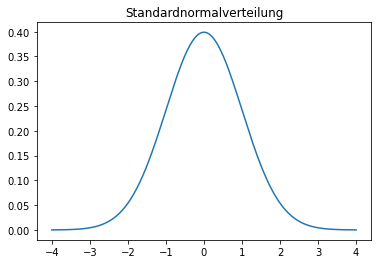

In [6]:
x_values = np.linspace(-4, 4, 400)
plt.title("Standardnormalverteilung")
plt.plot(x_values, gaussian(x_values, 0, 1))
plt.show()

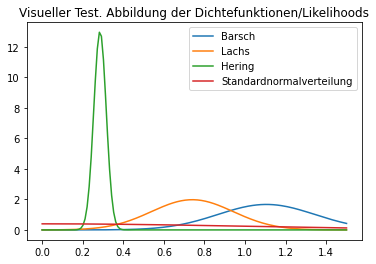

In [7]:
# Das hier geht natürlich mit Pandas und DataFrames auch alles schöner, aber sollte ja von Hand gemacht werden. Deshalb habe ich darauf verzichtet.
x_values = np.linspace(0, 1.5, 150)
for mean, var, l in [(mean_barsch, var_barsch, "Barsch"), (mean_lachs, var_lachs, "Lachs"), (mean_hering, var_hering, "Hering"), (0, 1, "Standardnormalverteilung")]:
    plt.plot(x_values, gaussian(x_values, mean, var), label=l)
    
plt.title("Visueller Test. Abbildung der Dichtefunktionen/Likelihoods")
plt.legend()
plt.show()

## Aufgabe 2
Implementieren Sie eine Funktion `priors(classes)`, die für einen Vektor von Klassen-Labels den Prior $p(x)$ für jede Klasse ausgibt.
Die Eingabe soll ein Array von Klassen sein (z.b. `np.array(["stand","sit","sit","stand"])`). Die Ausgabe soll ein Data Frame mit den Spalten `class` und `prior` sein.

In [8]:
import numpy as np
import pandas as pd

from pandas import Series, DataFrame

# Ich bin an dieser Stelle etwas von der Aufgabenbeschreibung abgewichen und habe eine Funktion geschrieben, die eine pandas Series entgegen nimmt und die priors als Series zurückgibt, wobei die Klassen der Index sind.
def priors(classes: Series) -> Series:
    # value_counts() zählt die Anzahl der vorkommen der Werte. Vergleichbar zu groupby -> count. Die Division wird elementweise angewendet und ist eine Fließkommaoperation.
    return classes.value_counts() / len(classes)
    
# Kleiner Test
pp = priors(Series(["stand","sit","sit","sit","stand"]))
print(pp)

sit      0.6
stand    0.4
dtype: float64


## Aufgabe 3
Implementieren Sie eine Funktion `likelihood(data)`, die für ein Data Frame, bestehend aus einer Spalte $y$ und einer Spalte $x$, die Likelihood $p(y|x)$ für jede Klasse $x$ mit einer Normalverteilung approximiert, d.h. es soll für jede Klasse ein Mittelwert und eine Varianz ausgegeben werden.
Die Ausgabe soll also die Spalten `class`, `mean` und `variance` besitzen.

Plotten Sie die Likelihood für jede Klasse.

In [9]:
from scipy.io import arff

def likelihood(data: DataFrame) -> DataFrame:
    # Groupby und agg funktionieren so, wie man das von SQL erwarten würde. Das ["x"] sorgt dafür, dass der Parameter für agg kein DataFrame mit einer spalte sondern eine Series ist. Das macht den Umgang einfacher, weil kein Multiindex entsteht. 
    # Das Ergebnis wird unten dargestellt. Auch hier bin ich etwas von der Aufgabenstellung abgewichen und habe class nicht als Spalte, sondern als Index.
    return data.groupby(['class'])["x"].agg(["mean", "var"])
    
data = arff.loadarff('features1.arff')
df = pd.DataFrame(data[0])

dat = df.loc[:, ["AccX_mean","class"]]
dat.columns = ["x","class"]
lik = likelihood(dat)
lik

,mean,var
class,,
b'bike',523.545587,15.843081
b'downstairs',517.316002,18.523919
b'lie',467.870175,56.697558
b'run',527.009294,96.483175
b'sit',486.721946,71.790221
b'stand',528.594727,1.057665
b'upstairs',545.413484,62.520043
b'walk',525.170962,1.221023


## Aufgabe 4
Implementieren Sie eine Funktion mylda(newdat,lik,priors), die für eine neue Beobachtung `newdat` die wahrscheinlichste Klasse zurückgibt.

Testen Sie Ihre Implementierung auf dem Datensatz `features1.arff`. „Trainieren“ Sie die QDA (d.h. berechnen Sie likelihood und prior), und führen Sie dann für die gleichen Daten eine Klassifikation durch. Wie gut ist die Klassifikation?

In [16]:
from scipy.io import arff
import scipy.stats

def mylda(x: float, lik: DataFrame, prior: DataFrame) -> bytes: # Die Klassen sind Objekte vom Typ bytes
    
    # Hilfsfunktion für apply. Apply übergibt der genutzten Funktion immer eine Series, die ich hier entpacke, um sie in meine Gauß-Funktion zu schmeißen. Die Gauß-Funktion ist oben definiert.
    def calc_likelihood(series: Series):
        return gaussian(x, series["mean"], series["var"])
    
    # DataFrame.apply() wendet die übergebene Funktion normalerweise spaltenweise an. Mit axis=1 ändert man das auf zeilenweise. Weil das Ergebnis von calc_likelihodd ein skalar ist, ist liks eine Series mit dem gleichen Index wie lik.
    liks = lik.apply(calc_likelihood, axis=1)
    
    # Weil liks und prior den gleichen Index haben (die Klassen werden als Index verwendet), funktioniert diese elementweise Multiplikation genau so, wie wir das brauchen. Series.idxmax() gibt den Indexwert des Maximums zurück, ist also vergleichbar mit argmax.
    return (liks * prior).idxmax()

mylda(523.0, lik, priors(dat["class"]))

b'bike'

In [11]:
pri = priors(dat["class"])
pri

b'bike'          0.257062
b'walk'          0.217514
b'run'           0.163842
b'lie'           0.096045
b'downstairs'    0.081921
b'upstairs'      0.076271
b'sit'           0.062147
b'stand'         0.045198
Name: class, dtype: float64

In [12]:
# Kopie vom DataFrame dat, um dat nicht zu verändern.
res = dat

# Zum Test verwende ich wieder apply. Weil dat["x"] eine Series ist, muss keine Axe angegeben werden. Lambdas sind anonyme Funktionen in Python. Die Priors und Likelihood-Parameter werden hier also als Closure übergeben.
res["test"] = dat["x"].apply(lambda x: mylda(x, lik, pri))
# In res stehen jetzt in der Spalte class die wahren Labels und in test die vorhergesagten.
res

,x,class,test
0,517.617188,b'downstairs',b'bike'
1,517.734375,b'downstairs',b'bike'
2,518.390625,b'downstairs',b'bike'
3,518.648438,b'downstairs',b'bike'
4,518.218750,b'downstairs',b'bike'
...,...,...,...
349,537.664063,b'upstairs',b'run'
350,538.601563,b'upstairs',b'run'
351,536.351563,b'upstairs',b'run'
352,539.898438,b'upstairs',b'upstairs'


In [13]:
# Die Accuracy beträgt 0.6638...
sum(res["class"] == res["test"]) / len(res)

0.6638418079096046